# ```TB_to_sympy```: Simplifying Hamiltonian Expressions for Condensed Matter Systems Within a Tight-Binding Model Framework.

## Introduction. ##

The tight-binding (TB) model is used in condensed matter physics to model the properties of conductors, semiconductors, and insulators. Experimental physicists often interact with the TB model during electronic band structure measurements, like angle-resolved photoemission spectroscopy (ARPES). They must verify that their experimental data aligns with theoretical predictions. The TB model's tractability offers a clear analytical solution, which proves efficient for experimentalists to quickly validate their data. Thus, there's a need for a function like ```TB_to_sympy```, which provides a reduced analytical Hamiltonian expression for the analyzed element.

If you model electrons as tightly bound to atoms, you get the TB model which assumes that main electronic behavior arises from interactions between neighboring atoms, where electrons hop between atomic orbitals through tunneling or wavefunction overlap.
The TB model is a minimal model that serves as a foundation for studying electron behavior in metals, including the origins of magnetism and superconductivity:
- For theorists, it reduces the number of parameters, from which they can study the effects of the parameters separately.
- For experimentalists, itâ€™s useful for a one-body description of the electronic structure. Therefore, if they can understand their data by using a simple representation like a TB model, their data can be understood simply. An analytical TB model with a restricted number of parameters can help experimentalists fit their data.

The ```TB_to_sympy``` function is designed to process a pre-constructed Tight-Binding (TB) model, transforming it into an analytic expression. This function does not generate a TB model on its own. Instead, it takes an existing TB model, which could either be derived from a Wannier90 calculation or represent a model Hamiltonian. The primary output of this function is the analytic representation of the input TB model, effectively translating its hopping amplitudes and other parameters into a symbolic form suitable for further analysis and manipulation.

The hopping amplitudes are obtained from the Wannier90 package, which fits the band structure obtained from density functional theory (DFT) for a set of orbitals. The larger the hopping amplitude, the more significant it is. For instance, a hopping amplitude of 0.00005 eV does not contribute as much to the movement of an electron as a hopping amplitude of 0.05 eV. There is a need for a cutoff either in the hopping distances or the hopping amplitudes. A minimal model can neglect these smaller amplitudes. Using the PythTB package's ```model``` function, we select only the hopping amplitudes bigger than the cutoff or smaller than the cutoff distance, restricting the hopping processes to be closer.

A generic form of a TB Hamiltonian reads:

$$
H = -\sum_{<i j> l_1 l_2 \sigma} t_{i j}^{l_1 l_2} [c^{\dagger}_{i l_1 \sigma} c_{j l_2 \sigma} + c^{\dagger}_{j l_2 \sigma} c_{i l_1 \sigma}]
$$

where:
- $t_{i j}^{l_1 l_2}$ is the hopping amplitude between orbital $l_1$ on site $i$ and orbital $l_2$ on site $j$.
- $\sigma$ is the spin and $c^{\dagger}$
- $c$ are creation and annihilation operators.

In this tutorial, we examine a system with one orbital and one site per unit cell. By performing a Fourier transform of the Hamiltonian from real space to momentum space, we obtain $H(k)$.

$$
H(k) = \frac{1}{(2\pi)^d} \sum_{R} e^{i k \cdot R} H_{R}
$$

### Function Definition and its Parameters. ###

Let us first import the necessary dependencies.

In [12]:
# importing the dependencies
from itertools import product as itp
from pythtb import *
from triqs.lattice.tight_binding import TBLattice
import sympy as sp
import warnings
import numpy as np
import matplotlib.pyplot as plt

# import all files from lattice in TRIQS

# # importing it from TRIQS repo
# from triqs.lattice.utils import TB_to_sympy

# importing it from this locala tutorials repo
from TB_to_sympy import TB_to_sympy

To view the documentation for the `TB_to_sympy` function, run the following cell. The documentation will appear in a pop-up window or an inline frame, showing the detailed description, parameters, and return values of the function.

In [13]:
help(TB_to_sympy)

Help on function TB_to_sympy in module TB_to_sympy:

TB_to_sympy(TBL, analytical=True, precision=6)
    returns the analytical form of the momentum space hamiltonian of the tight-binding model 
    from a tight-binding lattice object by utilizing Fourier series
    
    Parameters
    ----------
    TBL: triqs TBLattice object
        triqs tight binding object
    analytical: boolean, default = True
        whether to return the Hamiltonian in analytical (true) or numerical (false) form.
    precision: integer, default = 6
        specifies the number of digits in the floating point amplitudes. The default value is 6 but the user
        can decrease it to help recognize similar hopping amplitudes, particularly for symmetrical hoppings
        across the crystal lattice
    
    Returns
    -------
    Hk: NumPy array
        the Hamiltonian of the tight-binding model in momentum space. It can be output in either numerical
        form (Hk_numerical) or reduced analytical form (Hk) ba

Further explanation of the parameters:

The primary parameter required for our function is ```w90_triqs```, which is a TRIQS TBLattice Object (Tight-Binding Lattice Object). This object can be obtained in multiple ways. While it can be generated through conversion functions like ```TB_from_pythTB``` (converting a pythTB model to TRIQS TBLattice) or ```TB_from_wannier90``` (converting a Wannier90 model to TRIQS TBLattice), it's important to note that ```w90_triqs``` can also be directly defined without these conversion steps. This flexibility allows for a broader range of applications, accommodating both models derived from tools like pythTB or Wannier90 and those created explicitly as TRIQS TBLattice objects.

When using conversion functions, ```TB_from_pythTB``` is particularly useful for initiating cutoffs in your pythTB model before converting it to a TBLattice object. This is especially beneficial for complex systems, as it provides greater control over the model and allows for the examination of the output's behavior at different cutoffs. The available cutoff parameters in pythTB include:

1. ```zero_energy```: Sets the energy zero point in the band structure, typically aligned with the Fermi level.
2. ```min_hopping_norm```: Filters hopping terms based on their amplitudes, measured in electron volts. Terms with amplitudes below this threshold are excluded.
3. ```max_distance```: Excludes hopping distances beyond this specified maximum.

The ```analytical``` flag in the function determines the form of the default Hamiltonian returned by ```TB_to_sympy```. If set to ```False```, the Hamiltonian is in a 'numerical' form, which, despite the name, still depends on parameters like ```kx```, ```ky```, and ```kz```. For the purpose of this tutorial, we will refer to it as numerical, assuming the user can provide these k-space vector values.

Lastly, the ```precision``` parameter allows users to control the number of digits in the hopping amplitudes and lattice parameters, providing further customization and control over the modeling process.

## Calling the Function ##

Let us first load a model of $La_2CuO_4$, lanthanum copper oxide, a high-temperature superconductor:

In [14]:
from triqs.lattice.utils import TB_from_pythTB
# accessing the necessary Wannier90 output files
w90_input = w90('AbinitioDMFT/data/mlwf/', 'lco')
fermi_ev = 12.7367
w90_model = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = 0.05, max_distance = None)
w90_triqs_La2CuO4 = TB_from_pythTB(w90_model)

We can call ```TB_to_sympy``` for different cases depending on the values we assign to its parameters. Here is one case:

In [15]:
print("The analytical expression \n", TB_to_sympy(w90_triqs_La2CuO4, analytical = True, precision = 3))

The analytical expression 
 [[-0.88*cos(a1k + a3k) - 0.88*cos(a2k + a3k) + 0.159]]


In [16]:
print("The numerical expression \n", TB_to_sympy(w90_triqs_La2CuO4, analytical = False, precision = 3))

The numerical expression 
 [[-0.88*cos(3.818*kx) - 0.88*cos(3.818*ky) + 0.159]]


The key distinction between the analytical and numerical expressions lies in their respective use of basis vectors. The numerical expression utilizes Euclidean unit vectors and depends on ```kx```, ```ky```, and ```kz```. These unit vectors are standard Cartesian coordinates that represent points in the Euclidean space.

On the other hand, the analytical expression employs reciprocal basis vectors ```a1```, ```a2```, and ```a3```. These vectors define the orientation and shape of the crystal's unit cell in reciprocal space. The reciprocal lattice vectors are crucial in representing periodic structures and are used to express properties and behaviors of the crystal in terms of wave vectors.

It's important to understand this distinction because it reflects the different frameworks within which each expression operates. While the numerical expression is grounded in the familiar Euclidean space, the analytical expression is more closely aligned with the intrinsic properties of the crystal structure as represented in reciprocal space. This difference is not just mathematical but also conceptual, offering varied perspectives and tools for analyzing the behavior of the crystal.

Users can replace these lattice vectors with numerical values using the ```units``` function from the TRIQS TB lattice object. This conversion is particularly useful when translating the abstract concepts of lattice vectors into concrete numerical values for practical computations and analyses.

## Comparing Minimal Models ##

Let's create a figure to compare three minimal models, each with different `min_hopping_norm` cutoffs, against the full model from Wannier90. In the snippet below we compare 3 minimal models. You are free to choose the cutoffs you wish.

First, let us create a function that deals with making the minimal models:

In [17]:
def minimal_model(w90_input, fermi_ev, cutoff):
    """
    Constructs a minimal tight-binding model based on the input TRIQS TBLattice object.

    This function takes a pre-constructed TBLattice object, which represents the tight-binding 
    model of a crystal lattice, and applies additional parameters to refine the model.

    Parameters:
    w90_input (TBLattice): A TRIQS TBLattice object representing the tight-binding model. 
                           This object contains information about the lattice structure and 
                           hopping parameters.
    fermi_ev (float): The Fermi energy level in electron volts. This parameter sets the 
                      energy zero point in the band structure.
    cutoff (float): A threshold value to determine the significance of hopping terms in the 
                    model. Hopping terms with amplitudes below this cutoff are excluded from 
                    the calculations.

    Returns:
    A modified TBLattice object: This object represents the refined tight-binding model with 
    applied cutoffs and adjusted Fermi level, suitable for further analysis and computation.
    """

    # get band structure from Wannier90 in the form of
    # list of k-points in reduced coordinates
    # energies interpolated by Wannier90
    (w90_kpt, w90_evals) = w90_input.w90_bands_consistency()

    # obtain simplified model based on various cutoffs
    w90_model = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = cutoff, max_distance = None)

    # solve simplified model on the same k-path as in Wannier90
    return w90_model.solve_all(w90_kpt)

Next, let us set up the plot:

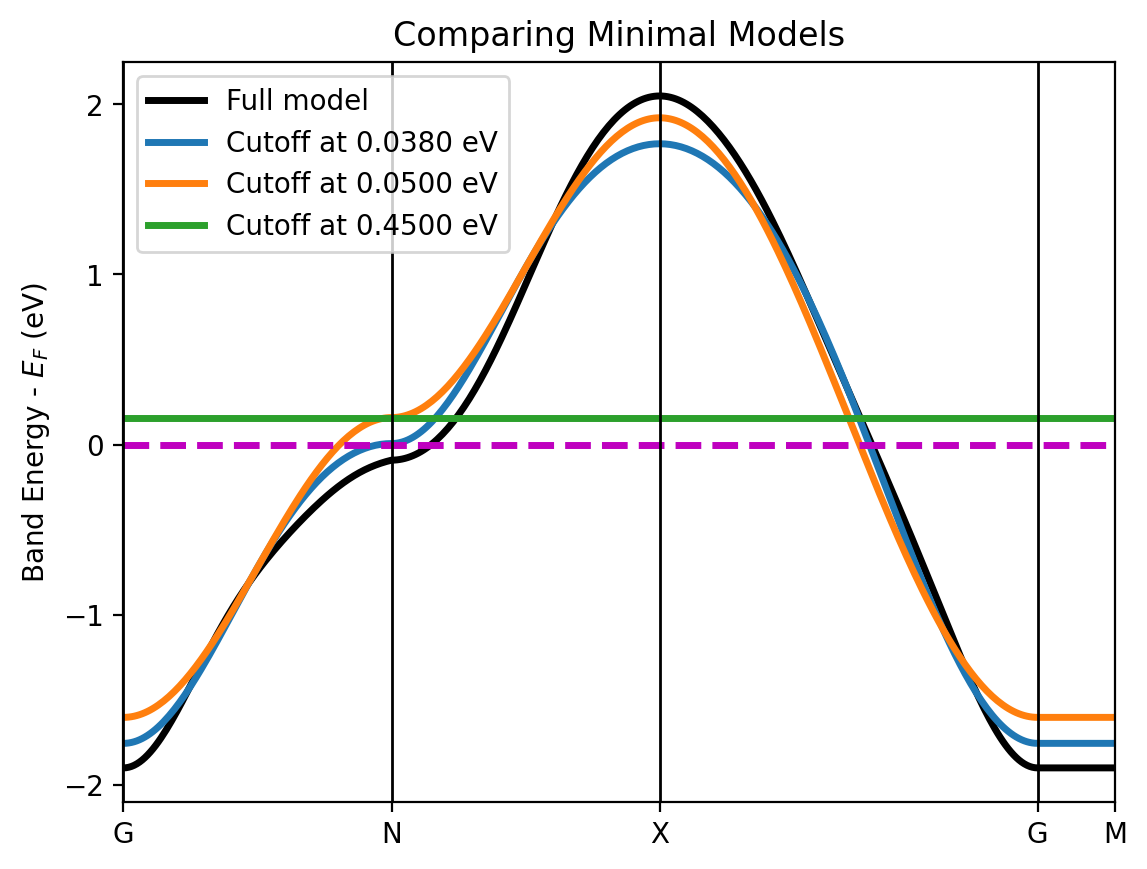

In [18]:
# setting up the plots
fig, ax = plt.subplots(dpi = 200)

# plotting the full Wannier90 model
(w90_kpt, w90_evals) = w90_input.w90_bands_consistency()
for i in range(w90_evals.shape[0]):
    x_axis = list(range(w90_evals.shape[1]))
    y_axis = w90_evals[i] - fermi_ev
    ax.plot(x_axis, y_axis, "k-", zorder = -100, label = "Full model")

# plotting the minimal models
for cutoff in [0.038, 0.05, 0.45]:
    int_evals = minimal_model(w90_input, fermi_ev, cutoff)
    for i in range(int_evals.shape[0]):
        ax.plot(list(range(int_evals.shape[1])), int_evals[i], zorder = -50, label = "Cutoff at %.4f eV" % cutoff)
    
# plotting the horizontal line that passes through the y-axis
ax.axhline(y = 0, color = 'm', linestyle = '--')
ax.set_yticks(np.arange(-2, 2.1, step = 1))

# increasing the width of the curves
lines = ax.lines
for line in lines:
    line.set_linewidth(2.5)

# coordinates of the high symmetry points
G = np.array([0.00, 0.00, 0.00])
N = np.array([0.25, -0.25, 0.25])
X = np.array([0.00, 0.00, 0.50])
M = np.array([0.25, 0.25, -0.25])

# x-axis labels of the high-symmetry points
kpath_labels = ['G', 'N', 'X', 'G', 'M']
idx_kpt = {}

# checking k-point coordinates equal to the high-symmetry point coordinates
for name, idx in (zip(('G', 'N', 'X', 'M'), [G, N, X, M])):
    idx_kpt[name] = list(np.where((w90_kpt == idx).all(axis = 1))[0])
    
# setting the x-axis ticks
kpath_xticks = list([x[0] for x in idx_kpt.values()])
kpath_xticks.append(idx_kpt['G'][1])
kpath_xticks = sorted(kpath_xticks)
ax.set_xticks(kpath_xticks)
ax.set_xticklabels(kpath_labels)

# setting the vertical lines at the high-symmetry points
for n in range(len(kpath_xticks)):
    ax.axvline(x = kpath_xticks[n], linewidth = 1, color = 'k')

# plot properties
ax.set_xlim(0, int_evals.shape[1] - 1)
ax.set_ylabel(r"Band Energy - $E_F$ (eV)")
ax.set_title("Comparing Minimal Models")
ax.legend()

The band structure's accuracy depends on the user's choice of ```min_hopping_norm``` and ```max_distance``` values. By adjusting these parameters, the cutoff model can closely resemble the full Wannier90 model while providing a concise analytical Hamiltonian expression. Below is a visual example illustrating this.

With a lower cutoff more hopping amplitudes are included which makes for a band structure that closely resembles the full Wannier90 band structure (which has all the hopping amplitudes present, that is, the full Wannier90 model includes all the hopping amplitudes when calculating the band energies across multiple k-paths).